In [193]:
import requests
import random
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from copy import deepcopy
from statistics import mean

In [194]:
def request() -> list:   
    res = requests.get('http://localhost:3000/api/ep1')
    return res.json()

In [195]:
def data_treatment(json:list) -> list:
    for i in range(len(json)):
        for key in json[i]:
            if ('prod' in key):
                if (type(json[i][key])!=dict):
                    qnt = json[i][key]
                    if (type(qnt)==str):
                        qnt = float(qnt)                  
                    if (qnt<0):
                        qnt = 0
                    if (key in [product for product in json[i] if ('prod' in product and (int(product[5]) < 9 and len(product) < 7))]):
                        json[i][key] = {'qnt':[round(qnt)], 'price':None}
                    else:
                        json[i][key] = {'qnt':[qnt], 'price':None}
        try:
            json[i]['date'] = time.ctime(json[i]['date'])
        except:
            continue
    return json

In [196]:
def generate_random_price(n_min=1.0, n_max=100.0) -> float:
    return round(random.uniform(n_min, n_max), 2)

In [197]:
def logistic_function(v: float) -> float:
    return 0.5 + (1 / (1 + math.e ** -v))

In [198]:
def calc_qnt_variation(last_week: list, current_week: list) -> float:
    return mean(current_week) - mean(last_week) / mean(last_week) if (mean(last_week) != 0) else 0

In [199]:
def calc_new_price(product_db: dict, sales_week: dict) -> dict:
    for product in product_db:
        if (product_db[product]['qnt'] != None):
            if (product not in sales_week.keys()):
                sales_week[product] = [0]
            product_db[product]['next_week_price'] = logistic_function(calc_qnt_variation(product_db[product]['qnt'], sales_week[product])) * product_db[product]['price']
        product_db[product]['qnt'] = sales_week[product]               
    return product_db

In [200]:
def product_pricing(json: list, product_db: dict) -> tuple:
    sales_week = {}

    for transaction in json:
        for key in transaction:
            if ('prod' in key):
                if (key not in product_db.keys()):
                    transaction[key]['price'] = generate_random_price()
                    sales_week[key] = deepcopy(transaction[key]['qnt'])
                    product_db[key] = deepcopy(transaction[key])
                    product_db[key]['qnt'] = None
                    product_db[key]['next_week_price'] = product_db[key]['price']              
                else:
                    transaction[key]['price'] = deepcopy(product_db[key]['next_week_price'])
                    product_db[key]['price'] = product_db[key]['next_week_price']
                    if (key not in sales_week.keys()):
                        sales_week[key] = deepcopy(transaction[key]['qnt'])
                    else:
                        sales_week[key] += deepcopy(transaction[key]['qnt'])
    product_db = calc_new_price(product_db, sales_week)
    return json, product_db

In [207]:
def df_to_all_df(json: list, all_df: pd.DataFrame, week: int) -> pd.DataFrame:
    for transaction in json:
        json_to_df = deepcopy(transaction)
        date = json_to_df['date']
        id = json_to_df['id']
        del json_to_df['date']
        del json_to_df['id']
        df = pd.DataFrame(json_to_df).T
        df['id'] = id
        df['date'] = date
        df['month'] = pd.to_datetime(df['date']).dt.to_period('M')
        df['week'] = week
        df = pd.concat([all_df, df])
        # df=df.set_index(['date','id'])
    return df

In [208]:
def format_all_df(all_df:pd.DataFrame) -> pd.DataFrame:
    all_df=all_df.reset_index().rename(columns={'index':'product'}).set_index('id').reset_index()
    all_df['qnt'] = [float(item[0]) for item in all_df['qnt']]
    return all_df

In [209]:
sum_all_prods = {f'prod_{i}':'sum' for i in range(20)}
sum_all_prods['balance']='sum'

In [210]:
def consolidate(df_qnt, df_price, df_consolidate):
    for prod in df_qnt.columns:
        df_consolidate[prod]=df_qnt[prod]*df_price[prod]
    return df_consolidate

In [211]:
def balance_product(df):
    list = []
    for row in df.index:
        list.append(df.loc[row].sum())
    return list

In [212]:
product_database = {}
weeks = 8
all_df = pd.DataFrame([])

for week in range(weeks):
    json = data_treatment(request())
    json, product_database = product_pricing(json, product_database)

    all_df = df_to_all_df(json=json, all_df=all_df, week=week)
        
all_df=format_all_df(all_df=all_df)
all_df.to_csv('allsales.csv')

In [213]:
all_df.head()

,id,product,qnt,price,date,month,week,balance
0,lamvkeomppel4gnxyd,prod_0,35.0,45.06,Thu Oct 21 06:35:28 2021,2021-10,0,[35]
1,lamvkeomppel4gnxyd,prod_1,43.0,53.21,Thu Oct 21 06:35:28 2021,2021-10,0,[43]
2,lamvkeomppel4gnxyd,prod_4,6.0,16.8,Thu Oct 21 06:35:28 2021,2021-10,0,[6]
3,lamvkeomppel4gnxyd,prod_5,32.0,62.97,Thu Oct 21 06:35:28 2021,2021-10,0,[32]
4,lamvkeomppel4gnxyd,prod_7,18.0,17.43,Thu Oct 21 06:35:28 2021,2021-10,0,[18]


In [227]:
def plot_prod_qnt(all_df):
    group_qnt = all_df.groupby('product')['qnt'].sum()
    df_prod = pd.DataFrame(group_qnt)
    plot_prod = df_prod.plot(kind='bar')
    return plot_prod

In [232]:
def plot_month_balance(all_df):
    df_balance = all_df.copy()
    df_balance['balance'] = df_balance['qnt'] * df_balance['price']
    df_months_balance = pd.DataFrame(df_balance.groupby('month')['balance'].sum())
    plot_months = df_months_balance.plot(kind='pie', subplots=True)
    return plot_months

<AxesSubplot:xlabel='product'>

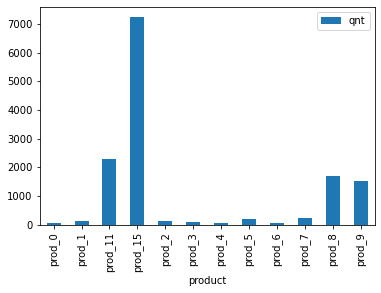

In [229]:
plot_prod_qnt(all_df)

array([<AxesSubplot:ylabel='balance'>], dtype=object)

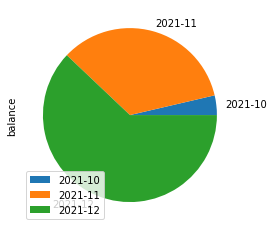

In [233]:
plot_month_balance(all_df) 